In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Ler/Importar Dataset
df = pd.read_csv('pns-2019_saude_mulher_tratado.csv')

In [3]:
def recod_escolaridade(x):
    if x in ["Sem instrução", "Creche", "Pré-escola"]:
        return "Baixa"
    elif x in [
        "Regular do ensino fundamental",
        "EJA do ensino fundamental",
        "Regular do ensino médio",
        "EJA do ensino médio"
    ]:
        return "Media"
    elif x in [
        "Superior - graduação",
        "Especialização (mín. 360h)",
        "Mestrado",
        "Doutorado"
    ]:
        return "Alta"
    else:
        return np.nan

df["Escolaridade_3cat"] = df["Escolaridade"].apply(recod_escolaridade)

In [4]:
def recod_estado_civil(x):
    if x == "Casada":
        return "Casada"
    elif x == "Solteira":
        return "Solteira"
    elif x in ["Divorciada", "Viúva"]:
        return "Outros"
    else:
        return np.nan

df["Estado_Civil_3cat"] = df["Estado_Civil"].apply(recod_estado_civil)

In [5]:
df["Classificacao_IMC"] = df["Classificacao_IMC"].replace(
    {"Não informado": np.nan}
)

In [6]:
viol_vars = [
    "Forcou_RelSexual_Vida",
    "Consequencia_psicologicas"
]

df[viol_vars] = df[viol_vars].fillna(0)

In [7]:
variaveis_finais = [
    "Depressao",
    "Idade",
    "Escolaridade_3cat",
    "Estado_Civil_3cat",
    "Classificacao_IMC",
    "Forcou_RelSexual_Vida",
    "Consequencia_psicologicas"
]

df_modelo_final = df[variaveis_finais].dropna(subset=["Depressao"])

df_modelo_final = pd.get_dummies(
    df_modelo_final,
    columns=[
        "Escolaridade_3cat",
        "Estado_Civil_3cat",
        "Classificacao_IMC"
    ],
    drop_first=True
)

In [8]:
from sklearn.model_selection import train_test_split

X = df_modelo_final.drop(columns="Depressao")
y = df_modelo_final["Depressao"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)



In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()
num_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features),
        ("num", "passthrough", num_features)
    ]
)


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  []),
                                                 ('num', 'passthrough',
                                                  ['Idade',
                                                   'Forcou_RelSexual_Vida',
                                                   'Consequencia_psicologicas',
                                                   'Escolaridade_3cat_Baixa',
                                                   'Escolaridade_3cat_Media',
                                                   'Estado_Civil_3cat_Outros',
                                                   'Estado_Civil_3cat_Solteira',
                                                   'Classificacao_IMC_Obesidade',
                                                   'Classificacao_IMC_Peso '
                                                   'normal',
                                                   'Classificacao_IMC_Sobrepeso'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

In [17]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.98      0.80      0.88     41569
           1       0.13      0.66      0.22      1913

    accuracy                           0.79     43482
   macro avg       0.56      0.73      0.55     43482
weighted avg       0.94      0.79      0.85     43482

ROC AUC: 0.7806550912893403


In [18]:
import pandas as pd
import numpy as np

# pegar o preprocessador JÁ FITADO
preprocess = rf_pipeline.named_steps["preprocess"]

# nomes das features após o one-hot + numéricas
feature_names = preprocess.get_feature_names_out()

# importâncias do Random Forest
importances = rf_pipeline.named_steps["model"].feature_importances_

# montar DataFrame
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(10)


,feature,importance
0,num__Idade,0.349490
7,num__Classificacao_IMC_Obesidade,0.295565
2,num__Consequencia_psicologicas,0.126170
9,num__Classificacao_IMC_Sobrepeso,0.070499
8,num__Classificacao_IMC_Peso normal,0.052808
1,num__Forcou_RelSexual_Vida,0.036376
5,num__Estado_Civil_3cat_Outros,0.035203
4,num__Escolaridade_3cat_Media,0.023496
6,num__Estado_Civil_3cat_Solteira,0.008632
3,num__Escolaridade_3cat_Baixa,0.001760


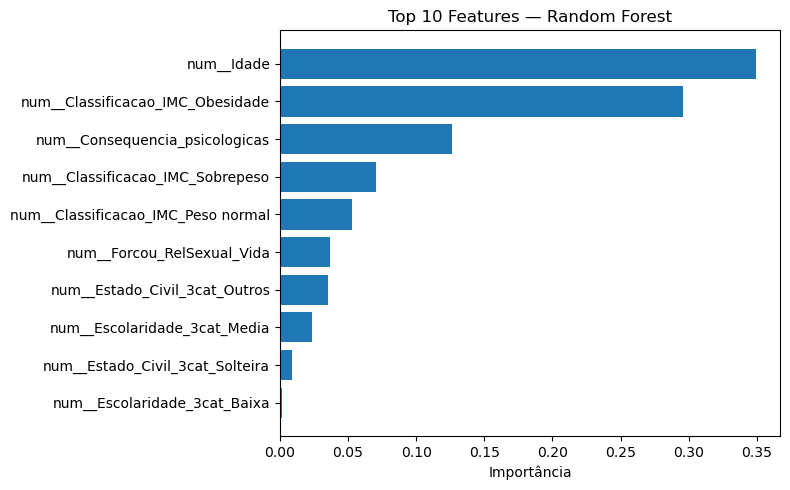

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feat_imp["feature"].head(10), feat_imp["importance"].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Features — Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

np.save("y_prob_rf.npy", y_prob_rf)
